In [511]:
import pandas as pd
import numpy as np
import nltk.data
import itertools
import spacy
from sentence_transformers import SentenceTransformer, util

In [2]:
df_clusters_raw = pd.read_csv("good_clusters_1.csv")

In [233]:
df_clusters = df_clusters_raw.drop_duplicates(subset=['lead'], keep='last')
df_clusters = df_clusters.drop_duplicates(subset=['headline'], keep='last')

In [300]:
list(set(df_clusters["cluster"]))[20:35]

[53, 56, 57, 59, 61, 66, 68, 69, 70, 75, 77, 78, 84, 86, 90]

In [369]:
cnum = 56
df_clust = df_clusters.loc[df_clusters["cluster"]==cnum]

In [372]:
df_clust["headline"].values

array(['Samsung heir braces for top court ruling in ex-president bribery case',
       'Samsung’s Leader at Risk of More Prison Time After Court Rules Against Him',
       "South Korea's top court orders review of ex-president Park's graft case",
       "South Korea top court returns Samsung heir Lee's bribery case for review",
       'S. Korean court sends Park, Samsung heir cases to new trials',
       "South Korea court ruling raises chance of Samsung heir's return to jail",
       'Samsung heir Lee Jae-yong faces retrial in bribery scandal that toppled a president',
       'Samsung heir faces return to prison in South Korea scandal',
       'At corruption retrial, Samsung scion may end up being jailed'],
      dtype=object)

In [448]:
set(df_clust["outlet"].values)

{'CBS News',
 'Los Angeles Times',
 'Reuters',
 'The New York Times',
 'The Washington Post'}

In [373]:
duplicate_headlines = []
model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')

for i in itertools.combinations(df_clust["headline"].to_list(), 2):
    sent_one = model.encode(i[0])
    sent_two = model.encode(i[1])

    #Compute dot score between query and all document embeddings
    scores = util.dot_score(sent_one, sent_two)[0].cpu().tolist()

    sen_tup1 = (i[0],"str")
    sen_tup2 = (i[1], "str")

    #Combine docs & scores
    doc_score_pairs = list(zip(sen_tup1, sen_tup2, scores))
    
    #Sort by decreasing score
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

    #Output passages & scores
    for doc, doc2, score in doc_score_pairs:
        if score > .85:
            print(score, doc, "####", doc2)
            duplicate_headlines.append(doc)

0.8705311417579651 South Korea court ruling raises chance of Samsung heir's return to jail #### Samsung heir faces return to prison in South Korea scandal


In [374]:
duplicate_headlines

["South Korea court ruling raises chance of Samsung heir's return to jail"]

In [375]:
df_clust.shape

(9, 18)

In [376]:
df_clust = df_clust.loc[~df_clust["headline"].isin(duplicate_headlines)]

In [377]:
df_clust.shape

(8, 18)

In [378]:
#df_clust

In [379]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [380]:
sentences_all = []
df_sentences = pd.DataFrame(columns=["outlet", "sentence"])
for index, row in df_clust.iterrows():
    sentence_list = tokenizer.tokenize(row['body']) 
    for sent in sentence_list:
        df_sentences = df_sentences.append({"outlet": row['outlet'], "sentence": sent}, ignore_index=True)

In [381]:
df_sentences.shape

(183, 2)

## Remove duplicate sentences

In [382]:
duplicate_sentences = []

for i in itertools.combinations(df_sentences["sentence"].to_list(), 2):
    sent_one = model.encode(i[0])
    sent_two = model.encode(i[1])

    #Compute dot score between query and all document embeddings
    scores = util.dot_score(sent_one, sent_two)[0].cpu().tolist()

    sen_tup1 = (i[0],"str")
    sen_tup2 = (i[1], "str")

    #Combine docs & scores
    doc_score_pairs = list(zip(sen_tup1, sen_tup2, scores))
    
    #Sort by decreasing score
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

    #Output passages & scores
    for doc, doc2, score in doc_score_pairs:
        if score > .98:
            print(score, doc, "####", doc2)
            duplicate_sentences.append(doc)

0.9999999403953552 FILE PHOTO: Samsung Electronics Vice Chairman Jay Y. Lee speaks at the company's headquarters in Seoul, South Korea, June 23, 2015. #### FILE PHOTO: Samsung Electronics Vice Chairman Jay Y. Lee speaks at the company's headquarters in Seoul, South Korea, June 23, 2015.
0.9623824954032898 REUTERS/Kim Hong-Ji/File Photo
The ruling will also determine how much Lee, 51, can focus on steering the group’s flagship Samsung Electronics Co Ltd through falling profitability and Japanese export curbs on materials crucial for the world’s leading chipmaker. #### The ruling cast doubt whether Lee, 51, can focus on steering the group’s flagship Samsung Electronics Co Ltd through falling profitability and Japanese export curbs on materials crucial for the world’s leading chipmaker.
0.9522315859794617 Lee, vice chairman of Samsung Electronics, was sentenced in 2017 to five years imprisonment for bribing a friend of former President Park Geun-hye as he sought to succeed his father and 

In [383]:
duplicate_sentences

["FILE PHOTO: Samsung Electronics Vice Chairman Jay Y. Lee speaks at the company's headquarters in Seoul, South Korea, June 23, 2015.",
 'REUTERS/Kim Hong-Ji/File Photo\nThe ruling will also determine how much Lee, 51, can focus on steering the group’s flagship Samsung Electronics Co Ltd through falling profitability and Japanese export curbs on materials crucial for the world’s leading chipmaker.',
 'Lee, vice chairman of Samsung Electronics, was sentenced in 2017 to five years imprisonment for bribing a friend of former President Park Geun-hye as he sought to succeed his father and secure control of Samsung Group.',
 'He was freed after a year in detention when the appellate Seoul High Court halved his sentence and suspended it for four years.',
 'Both Lee, who denies wrongdoing, and prosecutors appealed again.',
 'SEOUL, South Korea — South Korea’s top court on Thursday sent back jailed ex-President Park Geun-hye’s corruption case to a lower court for separate trials for her previou

In [384]:
df_sentences = df_sentences.loc[~df_sentences["sentence"].isin(duplicate_sentences)]

In [385]:
sentences_all_embed = df_sentences["sentence"].to_list()
sentences_all_embed

['SEOUL (Reuters) - Samsung Group will discover the fate of its de facto leader on Thursday as South Korea’s Supreme Court rules whether to uphold the bribery conviction of Jay Y. Lee, in a scandal that unseated the president and trained public ire on corporate untouchables.',
 'The Supreme Court is also set to rule on appeals court decisions in the cases against Park, who was impeached following the scandal and is serving a 25-year prison sentence, and her friend Choi Soon-sil, jailed for 20 years, both for bribery and other charges.',
 'Lee was the latest in a series of conglomerate bosses to be convicted of corruption but receive a lenient sentence, drawing public calls for reform of big businesses often criticized for overly close relationships with political leaders.',
 'The Supreme Court can uphold Lee’s conviction and suspended sentence, or ask the Seoul High Court to reconsider its judgment.',
 'That could lead to the conviction being overturned, or to a tougher sentence, legal

## Convert to sentence embeddings

In [386]:
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer

In [387]:
embedder = SentenceTransformer('all-MiniLM-L6-v2') # 'distilbert-base-nli-mean-tokens'

corpus_embeddings = embedder.encode(sentences_all_embed, show_progress_bar=True)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [388]:
len(corpus_embeddings)

169

## Perform clustering

In [487]:
# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.05, compute_distances=True) # 1.5 #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences_all_embed[sentence_id] + "777777")

In [488]:
for i, cluster in clustered_sentences.items():
    print("Cluster ", i)
    for article in cluster:
        print(article.split("###")[0])
    print("")

Cluster  0
SEOUL (Reuters) - Samsung Group will discover the fate of its de facto leader on Thursday as South Korea’s Supreme Court rules whether to uphold the bribery conviction of Jay Y. Lee, in a scandal that unseated the president and trained public ire on corporate untouchables.777777
The Supreme Court ruled that an appeals court had underestimated the value of the bribes that Lee Jae-yong, Samsung’s vice chairman, also known as J.Y.777777
The court is delivering its ruling on the corruption case that also involves Samsung Group’s de facto chief Jay Y. Lee.777777
Lee Jae-yong, the 51-year-old vice chairman of Samsung Electronics, paid millions of dollars worth of bribes in exchange for favors from South Korea’s disgraced former president, Park Geun-hye, according to the court.777777

Cluster  65
The Supreme Court is also set to rule on appeals court decisions in the cases against Park, who was impeached following the scandal and is serving a 25-year prison sentence, and her friend

In [489]:
df_sentences["cluster"] = clustering_model.labels_

In [490]:
df_sentences.head()

,outlet,sentence,cluster
0,Reuters,SEOUL (Reuters) - Samsung Group will discover ...,0
1,Reuters,The Supreme Court is also set to rule on appea...,65
2,Reuters,Lee was the latest in a series of conglomerate...,41
3,Reuters,The Supreme Court can uphold Lee’s conviction ...,30
4,Reuters,That could lead to the conviction being overtu...,58


## Remove clusters with only one outlet

In [491]:
one_outlet_clusters = []
for clust in df_sentences["cluster"].to_list():
    df_temp = df_sentences.loc[df_sentences["cluster"]==clust]
    if len(set(df_temp["outlet"])) < 2:
        one_outlet_clusters.append(clust)
        print(str(clust), set(df_temp["outlet"]))

58 {'Reuters'}
8 {'Reuters'}
8 {'Reuters'}
60 {'Reuters'}
44 {'Reuters'}
56 {'The Washington Post'}
61 {'The Washington Post'}
61 {'The Washington Post'}
57 {'The Washington Post'}
54 {'The Washington Post'}
4 {'The Washington Post'}
57 {'The Washington Post'}
68 {'The Washington Post'}
68 {'The Washington Post'}
55 {'The Washington Post'}
59 {'The Washington Post'}
50 {'The Washington Post'}
24 {'The Washington Post'}
24 {'The Washington Post'}
57 {'The Washington Post'}
61 {'The Washington Post'}
22 {'CBS News'}
12 {'CBS News'}
63 {'CBS News'}
22 {'CBS News'}
51 {'CBS News'}
71 {'CBS News'}
62 {'CBS News'}
31 {'CBS News'}
18 {'CBS News'}
21 {'CBS News'}
6 {'CBS News'}
31 {'CBS News'}
21 {'CBS News'}
37 {'CBS News'}
40 {'CBS News'}
36 {'CBS News'}
12 {'CBS News'}
10 {'CBS News'}
18 {'CBS News'}
10 {'CBS News'}
45 {'CBS News'}
6 {'CBS News'}
38 {'CBS News'}
9 {'Los Angeles Times'}
9 {'Los Angeles Times'}
47 {'Los Angeles Times'}
49 {'Los Angeles Times'}
64 {'Los Angeles Times'}
67 {'Lo

In [492]:
one_outlet_clusters = list(set(one_outlet_clusters))

In [493]:
df_sentences_filter = df_sentences.loc[~df_sentences["cluster"].isin(one_outlet_clusters)]

In [494]:
df_sentences.shape

(169, 3)

In [495]:
df_sentences_filter.shape

(112, 3)

In [496]:
df_sentences_filter[df_sentences_filter["cluster"]==0]["sentence"].values

array(['SEOUL (Reuters) - Samsung Group will discover the fate of its de facto leader on Thursday as South Korea’s Supreme Court rules whether to uphold the bribery conviction of Jay Y. Lee, in a scandal that unseated the president and trained public ire on corporate untouchables.',
       'The Supreme Court ruled that an appeals court had underestimated the value of the bribes that Lee Jae-yong, Samsung’s vice chairman, also known as J.Y.',
       'The court is delivering its ruling on the corruption case that also involves Samsung Group’s de facto chief Jay Y. Lee.',
       'Lee Jae-yong, the 51-year-old vice chairman of Samsung Electronics, paid millions of dollars worth of bribes in exchange for favors from South Korea’s disgraced former president, Park Geun-hye, according to the court.'],
      dtype=object)

## Remove low similarity sentences from clusters

In [497]:
list(set(df_sentences_filter["cluster"]))[:20]

[0, 1, 2, 3, 5, 7, 11, 13, 14, 15, 16, 17, 19, 20, 23, 26, 27, 28, 29, 30]

In [498]:
for clust_num in list(set(df_sentences_filter["cluster"])):
    scores_all = []
    df_sent_clust = df_sentences_filter[df_sentences_filter["cluster"]==clust_num]
    for i in itertools.combinations(df_sent_clust["sentence"].to_list(), 2):
        sent_one = model.encode(i[0])
        sent_two = model.encode(i[1])

        #Compute dot score between query and all document embeddings
        scores = util.dot_score(sent_one, sent_two)[0].cpu().tolist()

        sen_tup1 = (i[0],"str")
        sen_tup2 = (i[1], "str")

        #Combine docs & scores
        doc_score_pairs = list(zip(sen_tup1, sen_tup2, scores))

        #Sort by decreasing score
        doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

        #Output passages & scores
        for doc, doc2, score in doc_score_pairs:
            #print(score, doc, "####", doc2)
            scores_all.append(score)
#             if score > .8:
#                 print(score, doc, "####", doc2)
#                 scores_all.append(score)
    if np.mean(scores_all) > .75:
        print(clust_num, np.mean(scores_all), scores_all)

17 0.7923760612805685 [0.8421822786331177, 0.7704651355743408, 0.7644807696342468]
27 0.7829565207163492 [0.733332633972168, 0.8205838799476624, 0.7949530482292175]
33 0.7587360441684723 [0.7041144967079163, 0.7565847039222717, 0.8491698503494263, 0.6875014901161194, 0.8058279156684875, 0.7492178082466125]
35 0.7551030317942301 [0.7019957900047302, 0.861872136592865, 0.7014411687850952]
39 0.8113241195678711 [0.691402792930603, 0.8024882078170776, 0.7592604160308838, 0.8920288681983948, 0.8437268137931824, 0.879037618637085]
42 0.8478275140126547 [0.8881108164787292, 0.8080817461013794, 0.8472899794578552]
66 0.7595162391662598 [0.7595162391662598]
69 0.7694215774536133 [0.7694215774536133]


In [506]:
sent_clust_num = 27
df_sent_clust = df_sentences_filter[df_sentences_filter["cluster"]==sent_clust_num]
df_sent_clust["sentence"].values

array(['The Supreme Court said the interpretation by the Seoul High Court on what constituted bribes by Samsung to then-President Park Geun-hye was too narrow.',
       'But the Supreme Court ordered the Seoul High Court to deal with Park’s bribery charge separately from other charges, based on a law requiring so for cases involving a president or other elected officials, even when the alleged crimes are committed together.',
       'The retrial at the Seoul High Court was ordered Thursday by South Korea’s Supreme Court, which ruled that the total amount of Lee’s bribes provided to ex-President Park Geun-hye and her confidante had been underestimated.'],
      dtype=object)

In [500]:
set(df_sent_clust["outlet"])

{'CBS News', 'Reuters', 'The Washington Post'}

In [501]:
#" ".join(df_sent_clust["sentence"].values)

In [502]:
doc = nlp(df_sent_clust["sentence"].values[1])

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

last year 19 28 DATE
25 years 47 55 DATE


In [503]:
top_n_words[39][:15]

[('offering', 0.062421804437946225),
 ('friend', 0.06224378412354477),
 ('2017', 0.05990082440966672),
 ('longtime', 0.05469865952160024),
 ('ms', 0.05469865952160024),
 ('vice', 0.05402429633920817),
 ('sentenced', 0.05353685927964134),
 ('imprisonment', 0.04921900099870917),
 ('control', 0.04921900099870917),
 ('sil', 0.04496864764034327),
 ('soon', 0.04496864764034327),
 ('electronics', 0.04243957896468919),
 ('office', 0.04149585608236318),
 ('bolster', 0.03781230393859164),
 ('saga', 0.03781230393859164)]

In [504]:
len(set(df_sentences_filter["cluster"]))

34

In [525]:
df_sentences.loc[df_sentences["sentence"].str.contains("five")] #["sentence"].values

,outlet,sentence,cluster
23,The New York Times,"In August 2017, a Seoul district court sentenc...",39
33,Reuters,"Lee, vice chairman of Samsung Electronics, was...",39
51,The Washington Post,"In 2017, Lee, vice president of Samsung Electr...",39
62,The Washington Post,Park has been embroiled in two other smaller s...,57
78,CBS News,South Korean President Park Geun-hye removed f...,15
108,Los Angeles Times,He was initially sentenced to five years in pr...,43
113,Los Angeles Times,The finding could result in prison time for Le...,41
136,The Washington Post,A look at the latest saga of Lee and his busin...,39


In [519]:
df_sent_clust["sentence"].values

array(['The Supreme Court said the interpretation by the Seoul High Court on what constituted bribes by Samsung to then-President Park Geun-hye was too narrow.',
       'But the Supreme Court ordered the Seoul High Court to deal with Park’s bribery charge separately from other charges, based on a law requiring so for cases involving a president or other elected officials, even when the alleged crimes are committed together.',
       'The retrial at the Seoul High Court was ordered Thursday by South Korea’s Supreme Court, which ruled that the total amount of Lee’s bribes provided to ex-President Park Geun-hye and her confidante had been underestimated.'],
      dtype=object)

In [523]:
#doc = nlp("The Supreme Court is also set to rule on appeals court decisions in the cases against Park, who was impeached following the scandal and is serving a 25-year prison sentence, and her friend Choi Soon-sil, jailed for 20 years, both for bribery and other charges.")
doc = nlp(df_sent_clust["sentence"].values[2])

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

the Seoul High Court 15 35 ORG
Thursday 48 56 DATE
South Korea’s 60 73 GPE
Supreme Court 74 87 ORG
Lee 126 129 PERSON
Park Geun 164 173 PERSON


## c-TF-IDF

In [475]:
from sklearn.feature_extraction.text import CountVectorizer

In [476]:
df_sentences.head()

,outlet,sentence,cluster
0,Reuters,SEOUL (Reuters) - Samsung Group will discover ...,14
1,Reuters,The Supreme Court is also set to rule on appea...,8
2,Reuters,Lee was the latest in a series of conglomerate...,41
3,Reuters,The Supreme Court can uphold Lee’s conviction ...,13
4,Reuters,That could lead to the conviction being overtu...,9


In [477]:
#df_polusa['doc_id'] = range(len(df_polusa))
df_sentences.index = range(len(df_sentences))
docs_per_topic = df_sentences.groupby(['cluster'], as_index = False).agg({'sentence': ' '.join})

In [478]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [479]:
tf_idf, count = c_tf_idf(docs_per_topic["sentence"].values, m=len(docs_per_topic["sentence"]))

In [480]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic["cluster"])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster'])
                     .sentence
                     .count()
                     .reset_index()
                     .rename({"cluster": "cluster", "sentence": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [481]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(df_sentences)

In [482]:
topic_sizes.head(10)

,cluster,Size
2,2,8
14,14,8
0,0,7
23,23,7
19,19,7
8,8,6
16,16,6
13,13,6
15,15,6
32,32,6


In [483]:
#top_n_words[2][:10]

In [510]:
#nlp = spacy.load("en_core_web_sm")
doc = nlp("The Supreme Court is also set to rule on appeals court decisions in the cases against Park, who was impeached following the scandal and is serving a 25-year prison sentence, and her friend Choi Soon-sil, jailed for 20 years, both for bribery and other charges.")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

The Supreme Court 0 17 ORG
Park 86 90 PRODUCT
25-year 149 156 DATE
Choi Soon-sil 189 202 PERSON
20 years 215 223 DATE


In [509]:
import spacy
from spacy import displacy

# In[2]:
doc = nlp("The Supreme Court is also set to rule on appeals court decisions in the cases against Park, who was impeached following the scandal and is serving a 25-year prison sentence, and her friend Choi Soon-sil, jailed for 20 years, both for bribery and other charges.")
displacy.render(doc, style="dep")

# # In[3]:
# doc2 = nlp(LONG_NEWS_ARTICLE)
# displacy.render(doc2, style="ent")

## Named Entity Recognition (Spacy)

In [417]:
import spacy

In [430]:
# import en_core_web_sm
# nlp = en_core_web_sm.load()
nlp = spacy.load("en_core_web_sm")

In [431]:
doc = nlp("FILE PHOTO - Supporters of ousted President Park Geun-hye gather outside a court after a South Korean court jailed her for 24 years, in Seoul, South Korea, April 6, 2018.")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Park Geun 44 53 PERSON
South Korean 89 101 NORP
24 years 123 131 DATE
Seoul 136 141 GPE
South Korea 143 154 GPE
April 6, 2018 156 169 DATE


In [429]:
list(doc.ents)

[Park Geun, South Korean, 24 years, Seoul, South Korea, April 6, 2018]

## Visualization

In [45]:
#clustering_model.n_features_in_

In [46]:
#clustering_model.children_

In [47]:
#clustering_model.distances_

In [642]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [643]:
Z = hierarchy.linkage(clustering_model.children_, 'ward')


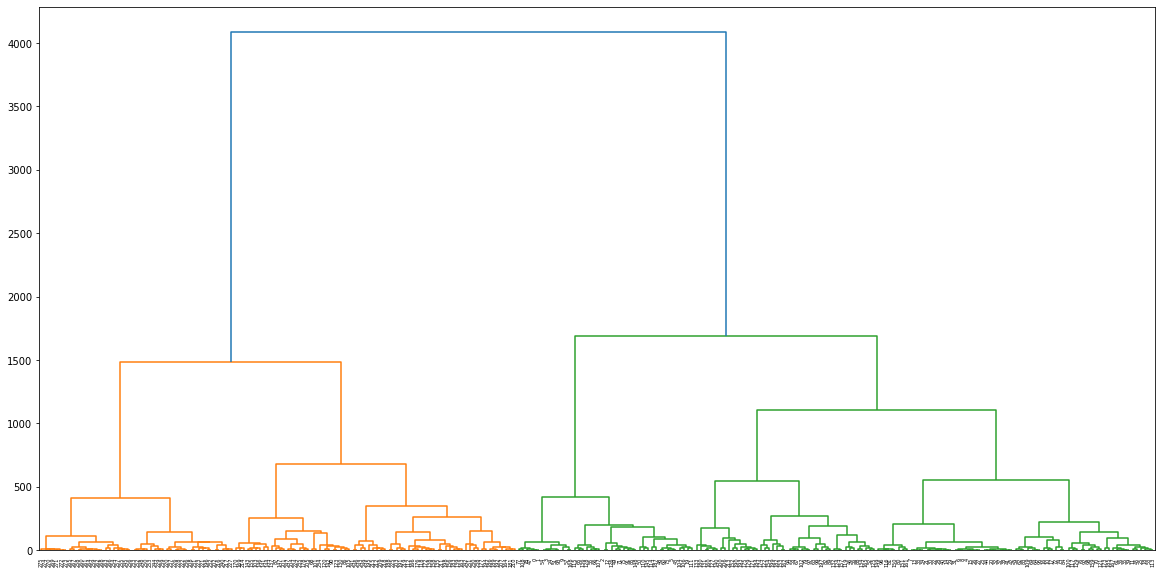

In [644]:
plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)

In [529]:
df_clust = df_clusters.loc[df_clusters["cluster"]==1]
df_clust

,Unnamed: 0,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,head_lead,cluster,doc_id,cluster_terms,match_terms,num_match,article_terms
0,3,45795486,2019-08-27 17:39:08,The Washington Post,Former Google engineer charged with trade secr...,A former Google engineer is being charged with...,"FILE- In this Dec. 13, 2016, file photo, Antho...",Michael Liedtke;August At Pm,www.washingtonpost.com,https://www.washingtonpost.com/national/former...,UNDEFINED,Former Google engineer charged with trade secr...,1,88,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'secret', 'uber', 'steal']",5,"['former', 'googl', 'engin', 'charg', 'trade',..."
1,4,2217569,2019-08-27 17:44:09,Reuters,U.S. charges former Alphabet engineer with ste...,The U.S. Department of Justice on Tuesday file...,FILE PHOTO: The U.S. Department of Justice bui...,Alexandria Sage;Min Read,www.reuters.com,https://www.reuters.com/article/us-autonomous-...,CENTER,U.S. charges former Alphabet engineer with ste...,1,90,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'uber', 'car', 'levandowski', 'antho...",6,"['us', 'charg', 'former', 'alphabet', 'engin',..."
2,5,115846749,2019-08-27 17:48:00,ABC News,Ex-Google engineer charged with stealing compa...,Anthony Levandowski has been charged with stea...,A former Google engineer spent months download...,Abc News,abcnews.go.com,https://abcnews.go.com/Business/google-enginee...,CENTER,Ex-Google engineer charged with stealing compa...,1,96,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'secret', 'uber', 'levandow...",6,"['exgoogl', 'engin', 'charg', 'steal', 'compan..."
3,6,55031808,2019-08-27 17:51:16,Los Angeles Times,Ex-Uber and Waymo engineer charged with trade ...,Anthony Levandowski is charged with stealing G...,Former Google engineer Anthony Levandowski is ...,The Associated Press Is An Independent;Not-For...,www.latimes.com,https://www.latimes.com/business/story/2019-08...,LEFT,Ex-Uber and Waymo engineer charged with trade ...,1,100,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'secret', 'uber', 'car', 'l...",7,"['exub', 'waymo', 'engin', 'charg', 'trade', '..."
4,7,39127870,2019-08-27 18:21:03,The Guardian,Former Google self-driving car engineer charge...,Anthony Levandowski worked on autonomous vehic...,Anthony Levandowski worked on autonomous vehic...,Julia Carrie Wong,www.theguardian.com,https://www.theguardian.com/technology/2019/au...,LEFT,Former Google self-driving car engineer charge...,1,148,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'uber', 'car', 'levandowski']",5,"['former', 'googl', 'selfdriv', 'car', 'engin'..."
5,8,55528577,2019-08-27 19:21:11,Yahoo! News,Ex-Google engineer charged with theft of auton...,A former Google engineer was hit with criminal...,"Anthony Levandowski, seen in a 2016 photo duri...",Glenn Chapman,news.yahoo.com,https://news.yahoo.com/ex-google-engineer-char...,CENTER,Ex-Google engineer charged with theft of auton...,1,198,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'secret', 'uber', 'car', 'l...",7,"['exgoogl', 'engin', 'charg', 'theft', 'autono..."
6,9,1557288,2019-08-27 19:38:43,Reuters,Timeline: Autonomous car pioneer Levandowski f...,The U.S. Department of Justice on Tuesday file...,(Reuters) - The U.S. Department of Justice on ...,Reuters Editorial;Min Read,www.reuters.com,https://www.reuters.com/article/us-autonomous-...,CENTER,Timeline: Autonomous car pioneer Levandowski f...,1,216,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'uber', 'car', 'levandowski', 'antho...",6,"['timelin', 'autonom', 'car', 'pioneer', 'leva..."
7,10,2614543,2019-08-27 19:40:05,Reuters,U.S. charges ex-Alphabet engineer with stealin...,The U.S. Department of Justice on Tuesday file...,(Reuters) - The U.S. Department of Justice on ...,Alexandria Sage;Min Read,www.reuters.com,https://www.reuters.com/article/us-autonomous-...

In [530]:
len(set(df_clust["outlet"]))

6

In [532]:
set(df_clust["outlet"])

{'ABC News',
 'Los Angeles Times',
 'Reuters',
 'The Guardian',
 'The Washington Post',
 'Yahoo! News'}

In [540]:
df_clust.loc[df_clust["body"].str.contains("fined")] #["body"].values

,Unnamed: 0,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,head_lead,cluster,doc_id,cluster_terms,match_terms,num_match,article_terms
0,3,45795486,2019-08-27 17:39:08,The Washington Post,Former Google engineer charged with trade secr...,A former Google engineer is being charged with...,"FILE- In this Dec. 13, 2016, file photo, Antho...",Michael Liedtke;August At Pm,www.washingtonpost.com,https://www.washingtonpost.com/national/former...,UNDEFINED,Former Google engineer charged with trade secr...,1,88,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'secret', 'uber', 'steal']",5,"['former', 'googl', 'engin', 'charg', 'trade',..."
3,6,55031808,2019-08-27 17:51:16,Los Angeles Times,Ex-Uber and Waymo engineer charged with trade ...,Anthony Levandowski is charged with stealing G...,Former Google engineer Anthony Levandowski is ...,The Associated Press Is An Independent;Not-For...,www.latimes.com,https://www.latimes.com/business/story/2019-08...,LEFT,Ex-Uber and Waymo engineer charged with trade ...,1,100,"['secret', 'engin', 'steal', 'googl', 'levando...","['engin', 'googl', 'secret', 'uber', 'car', 'l...",7,"['exub', 'waymo', 'engin', 'charg', 'trade', '..."
